In [1]:
from scipy.stats import beta
from data_formats import read_data
from dose_reponse_fit import dose_response_fit, StandardSettings
import matplotlib.pyplot as plt
from plotting import *
from stress_survival_conversion import stress_to_survival, survival_to_stress
import random
import glob
from tqdm import tqdm
import pandas as pd
import sympy
import numpy as np
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split
from scipy.optimize import fsolve
from scipy.optimize import brentq
from stress_addition_model import sam_prediction

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


$0.159 x_{0} - 0.0554 + \frac{1}{\sqrt{- x_{0} + \frac{1}{x_{0}}} + \tanh{\left(x_{0} \right)}}$

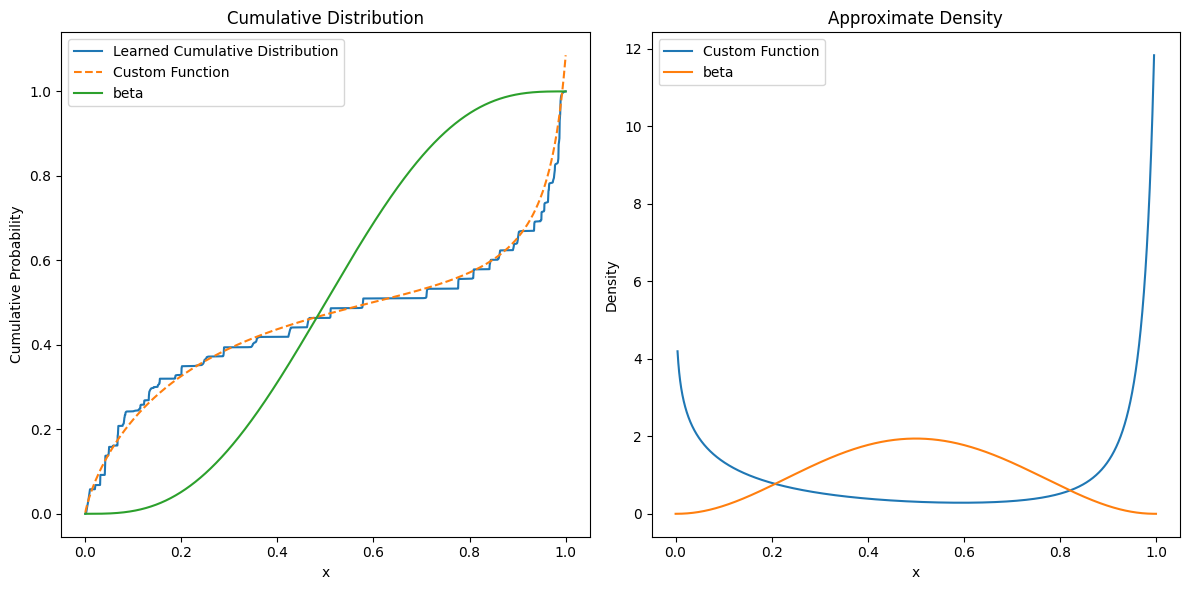

In [2]:
df = pd.read_csv("better.csv")

x = df.right_borders.values
y = np.cumsum(df.probs).values

def compute_x(x0):
    if np.any(x0 <= 0):  # To avoid log and division errors for non-positive values
        raise ValueError("x0 must be positive.")
    
    term1 = 0.000995
    numerator = np.log(0.907 * x0)
    denominator = x0 - (1.09 / x0)
    
    x = term1 + numerator / denominator
    return x

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x, y, label="Learned Cumulative Distribution")
plt.plot(x, compute_x(x), label="Custom Function", linestyle="--")
plt.plot(x, beta.cdf(x, 3.2, 3.2), label = "beta")
plt.title("Cumulative Distribution")
plt.xlabel("x")
plt.ylabel("Cumulative Probability")
plt.legend()

# Approximate the density (taking the derivative of the cumulative distribution)
density = np.gradient(compute_x(x), x)

# Plot the approximate density on the right
plt.subplot(1, 2, 2)
plt.plot(x[20:-20], density[20:-20], label="Custom Function")
plt.plot(x, beta.pdf(x, 3.2, 3.2), label = "beta")
plt.title("Approximate Density")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()

In [3]:
def surv_to_stress_new(x0):
    x0 = np.clip(x0, 1e-7, 1-1e-7)
    x0 = 1 - x0  # Adjusting the input
    term1 = 0.000995
    numerator = np.log(0.907 * x0)
    denominator = x0 - (1.09 / x0)
    x = term1 + numerator / denominator
    return x

# Define the stress_to_surv_new function (inverse using brentq)
@np.vectorize
def stress_to_surv_new(y):
    y = np.clip(y, 1e-7, 1-1e-7)
    
    # Define the equation we want to solve: surv_to_stress_new(x0) = y
    def equation(x0):
        return surv_to_stress_new(x0) - y

    # Use brentq to find the root of the equation in the interval [0, 1]
    try:
        x0_inverse = brentq(equation, 0.001, 1)  # Start from a small positive value to avoid division by zero
        return x0_inverse
    except ValueError as e:
        raise ValueError(f"Cannot find a root in the interval [0, 1] for y = {y}. Error: {e}")


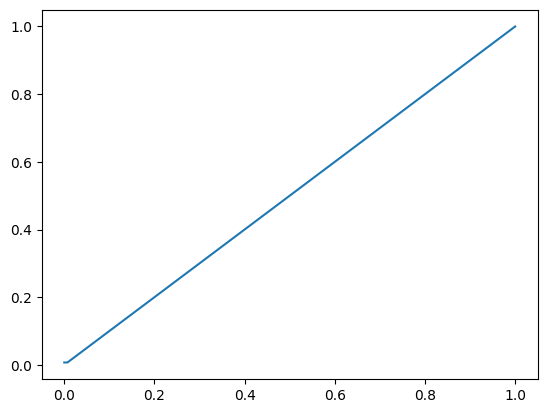

In [4]:
x = np.linspace(0, 1,1000)
y = surv_to_stress_new(x)
inverse = stress_to_surv_new(y)
plt.plot(x,inverse)

In [5]:
files = []

for i in glob.glob("data/*.xlsx"):
    data = read_data(i)
    
    # if data.meta.chemical in ["Clothianidin", "Esfenvalerate", "BPS"]:
    files.append(data)
        
        
fits = []
for data in files:
    data : ExperimentData
    for stressor in data.additional_stress:
        
        settings = StandardSettings(survival_max=data.meta.max_survival)

        main_fit = dose_response_fit(data.main_series, settings)

        stress_fit = dose_response_fit(data.additional_stress[stressor], settings)
        
        fits.append((data, stressor, main_fit, stress_fit))
xs, ys = [], []
main_c0, stress_c0 = [], []

for data, stressor, main_fit, stress_fit in fits:
    
    main_fit : ModelPredictions
    stress_fit : ModelPredictions
    
    if stress_fit.optim_param["d"] > main_fit.optim_param["d"]:
        print("dropping")
        continue
    
    xs.append(main_fit.survival_curve / data.meta.max_survival)
    main_c0.append(main_fit.optim_param["d"])
    stress_c0.append(stress_fit.optim_param["d"])
    
    ys.append(stress_fit.survival_curve / data.meta.max_survival)
    
    
toxicant_surv = np.array(xs)
stres_surv = np.array(ys)
main_c0 = np.array(main_c0)
stress_c0 = np.array(stress_c0)
toxicant_surv.min(), toxicant_surv.max(), stres_surv.min(), stres_surv.max(), toxicant_surv.shape, stres_surv.shape

(0.00017854006518621809,
 0.9999996553905022,
 8.132729453932944e-07,
 0.9999999083250408,
 (42, 10000),
 (42, 10000))

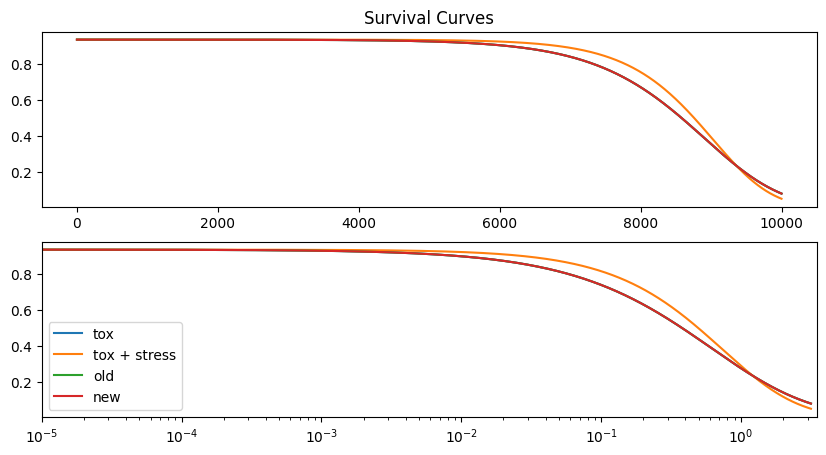

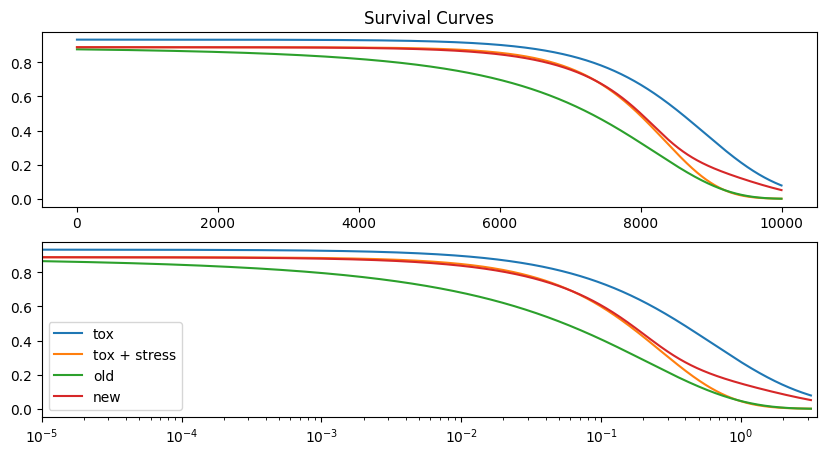

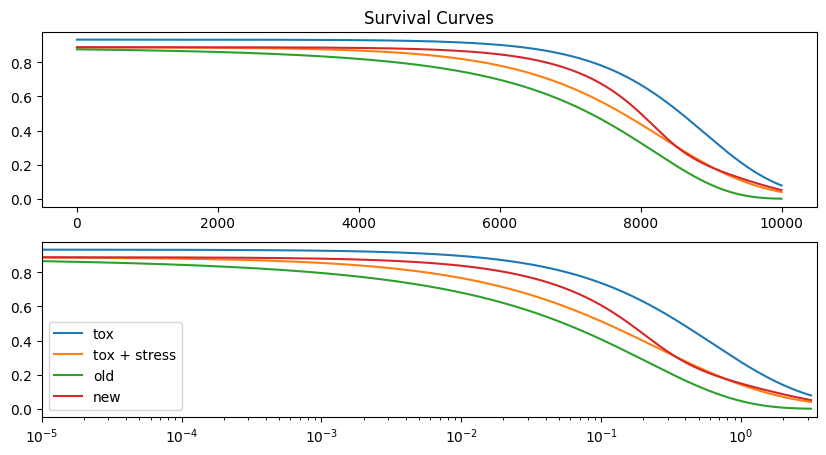

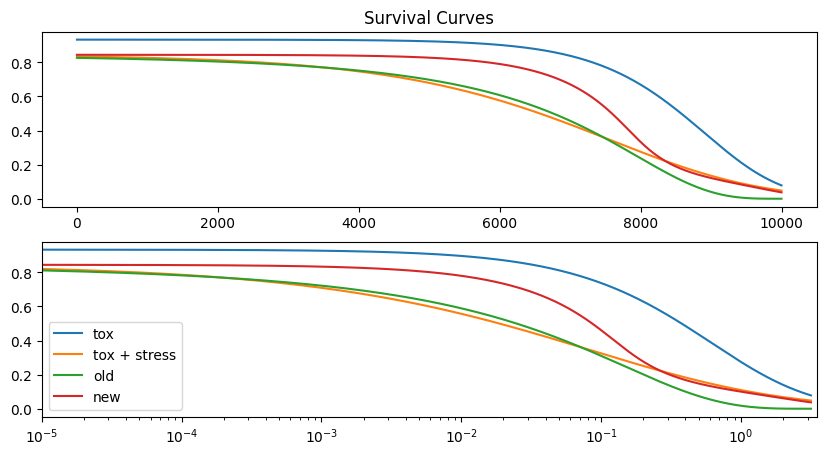

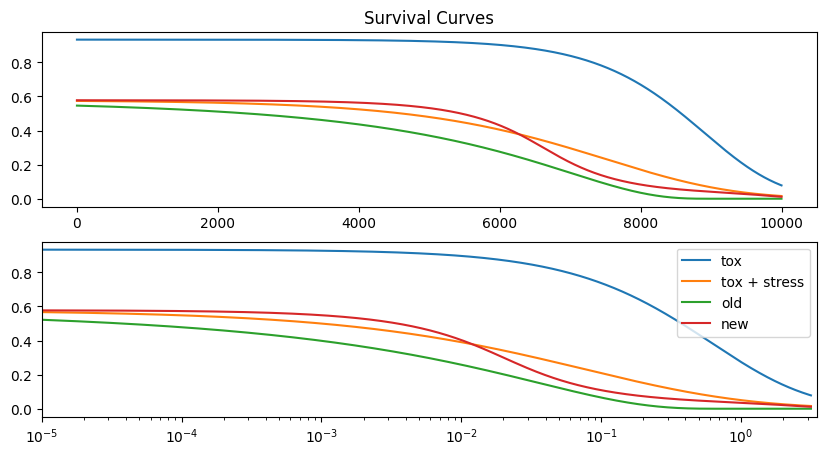

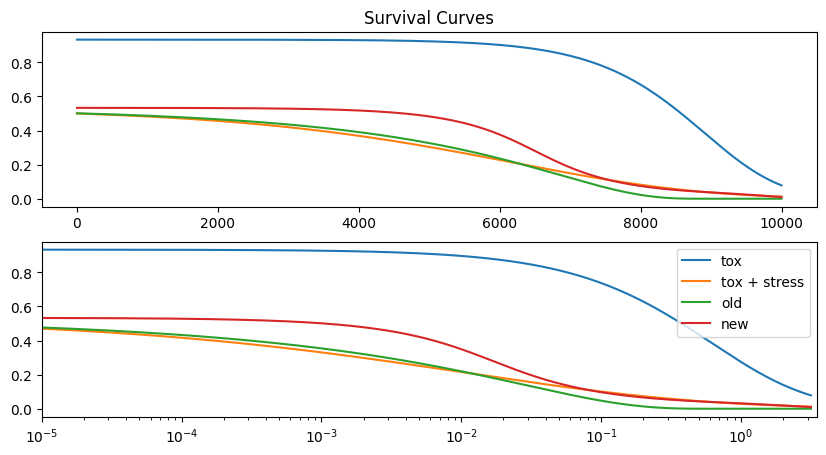

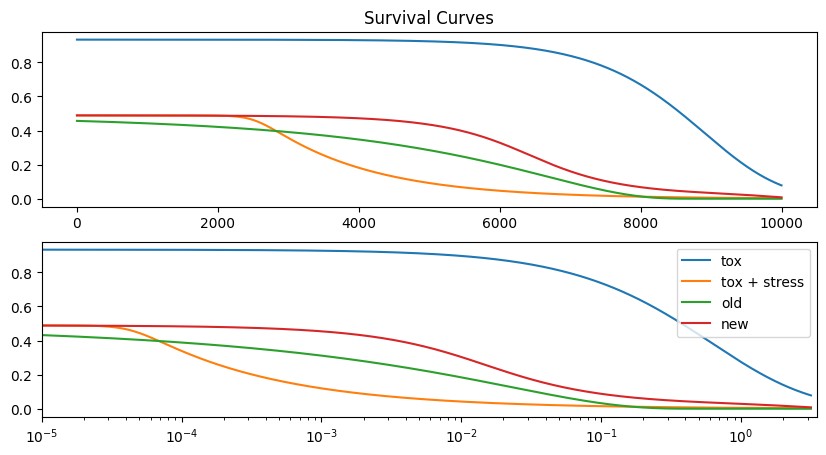

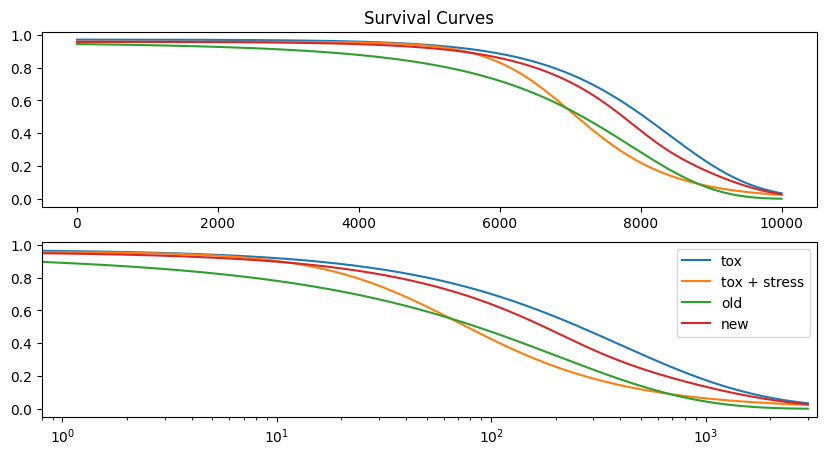

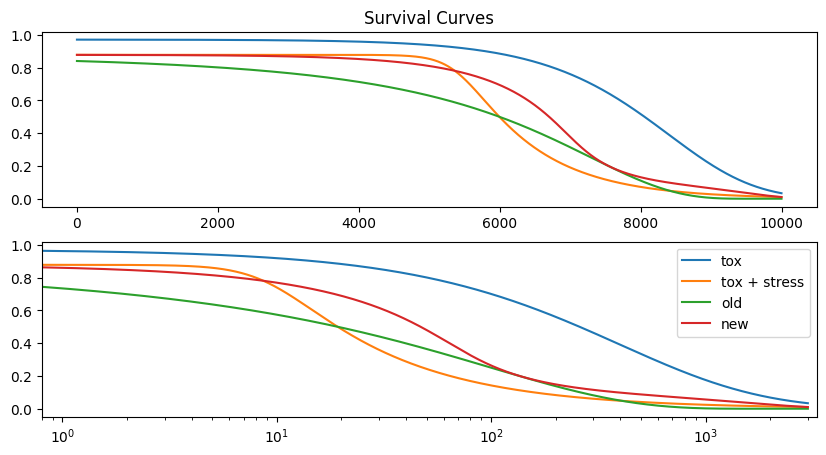

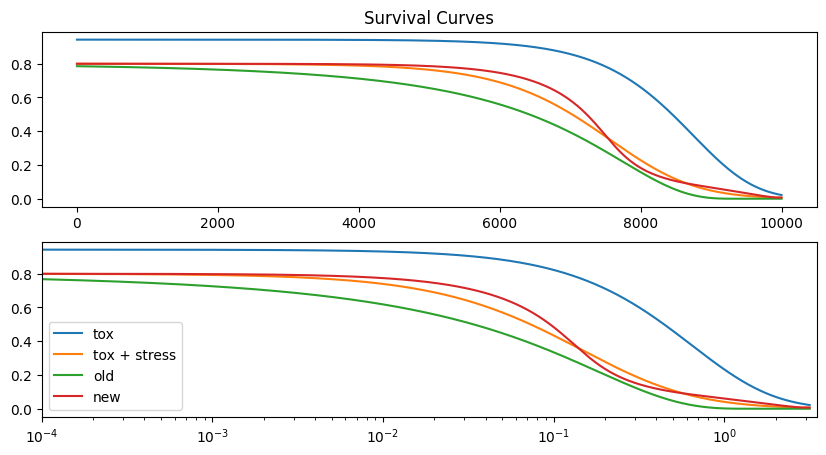

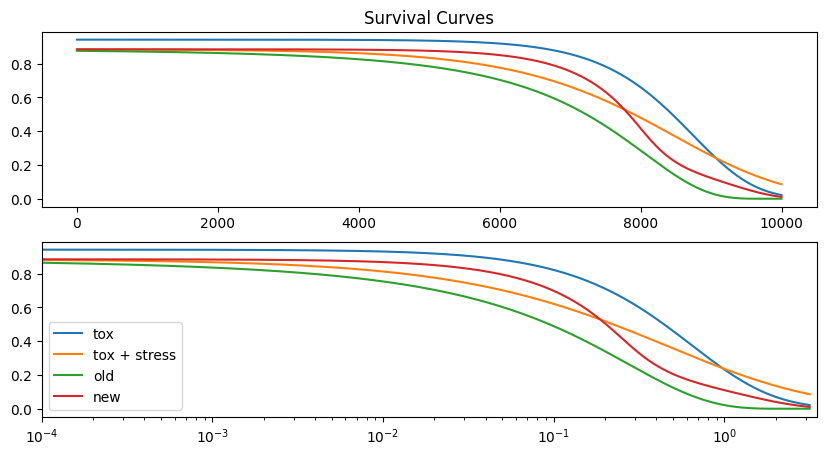

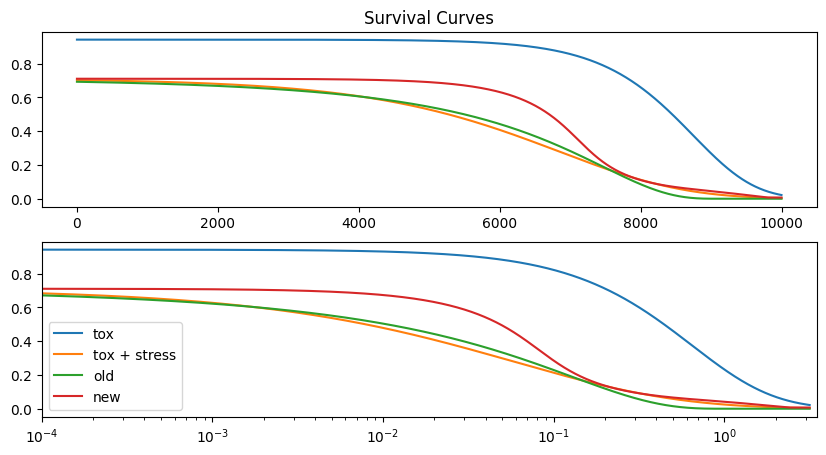

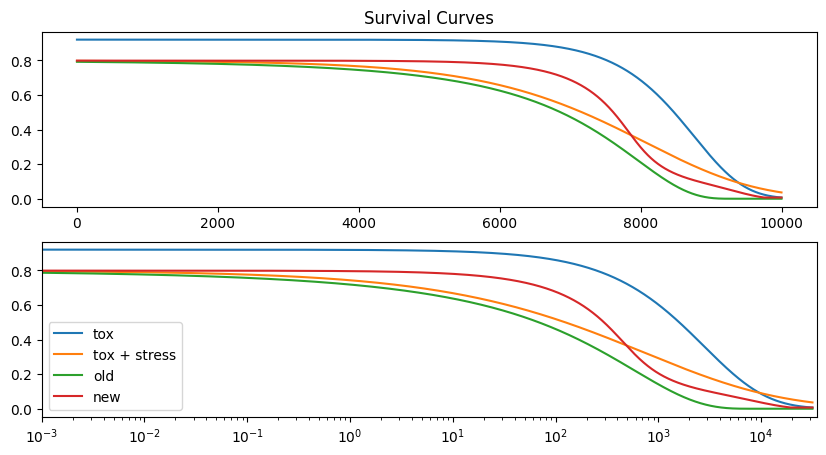

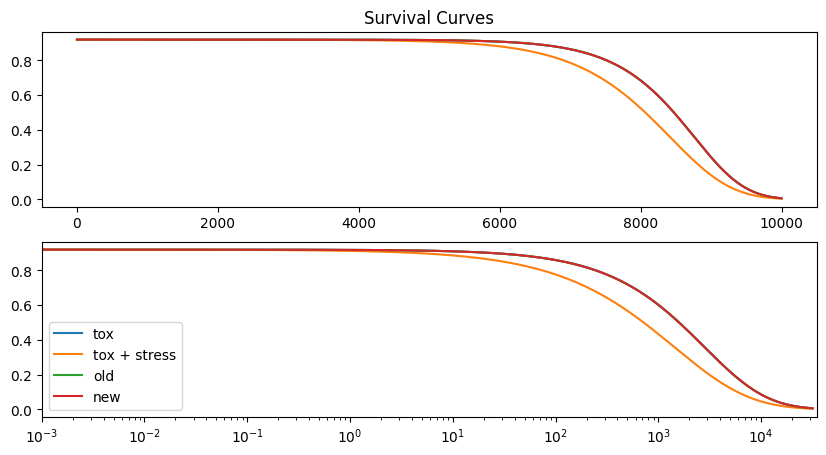

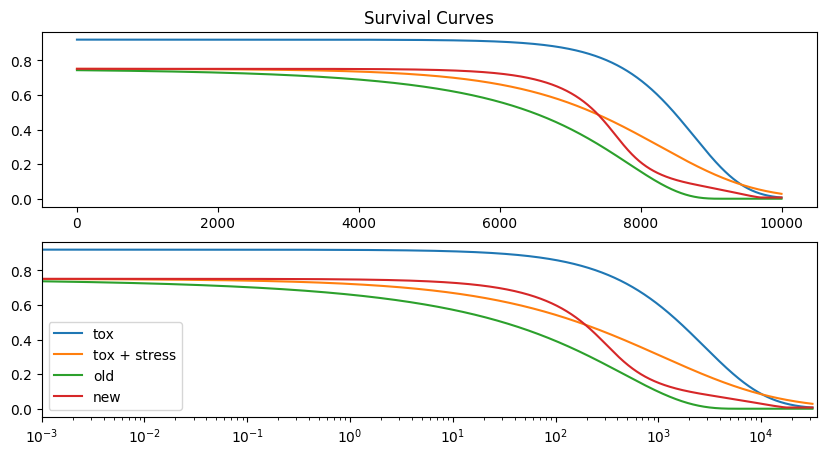

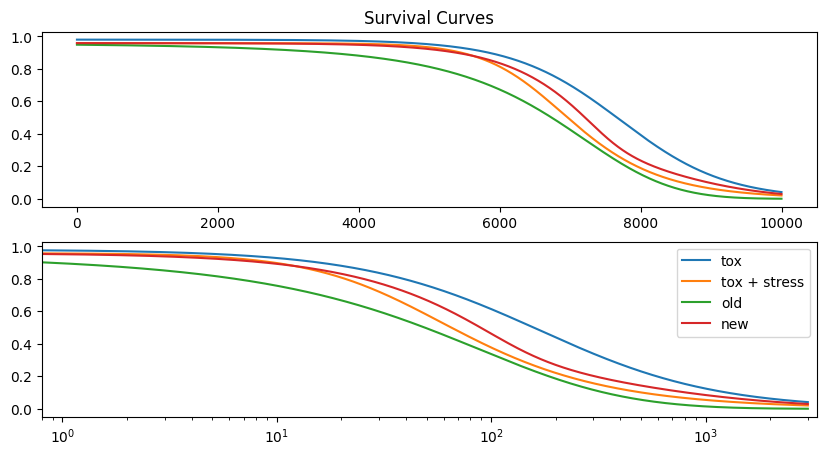

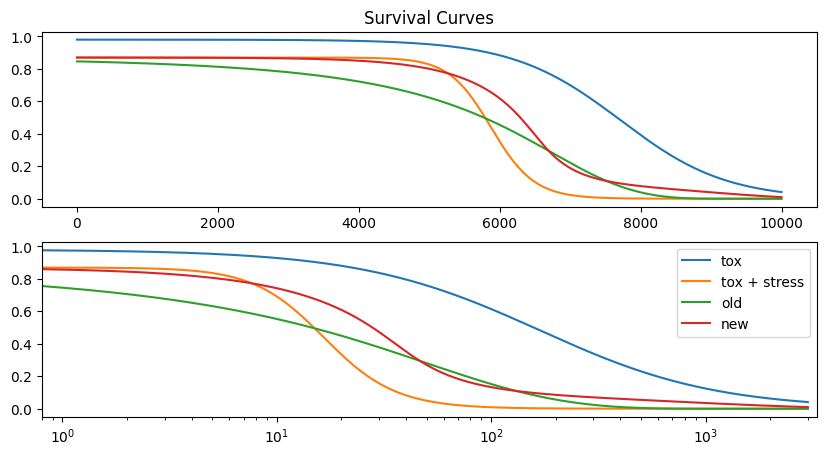

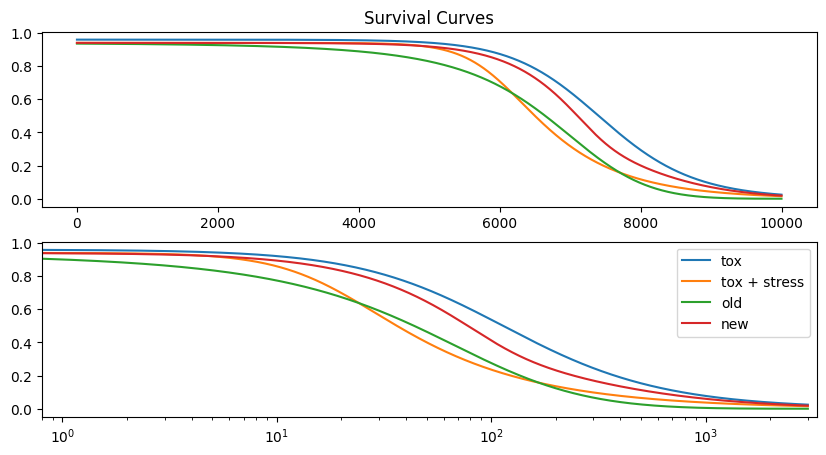

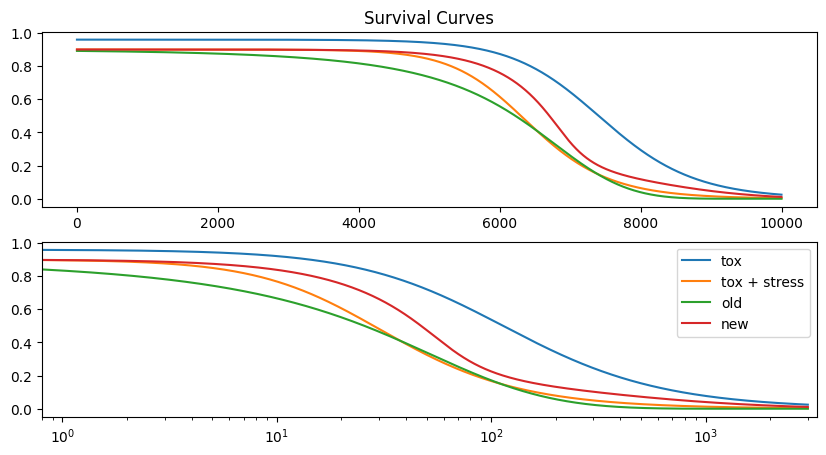

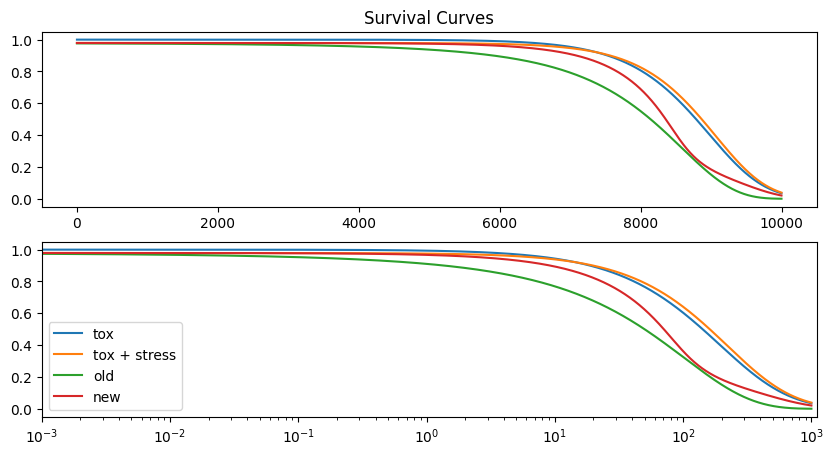

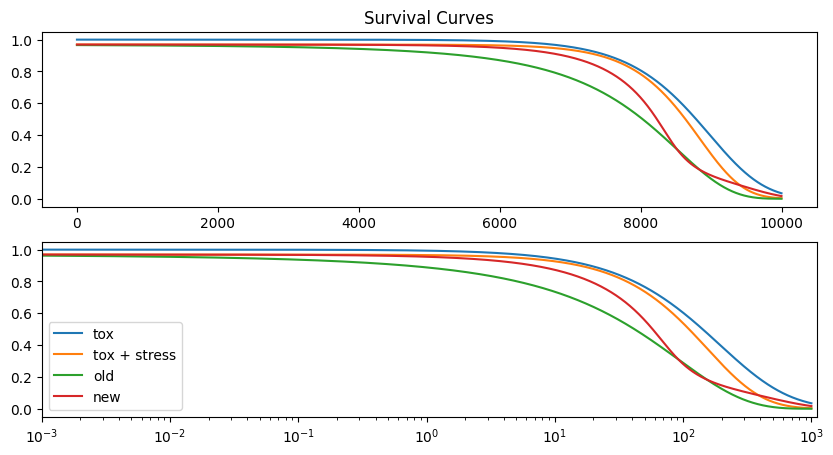

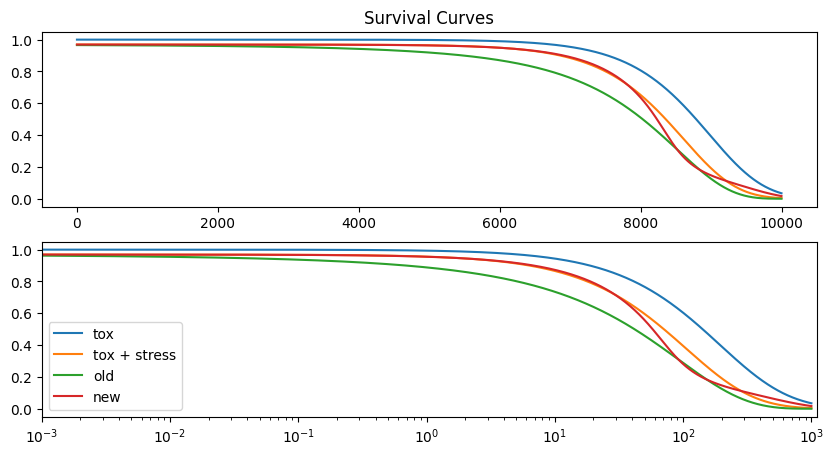

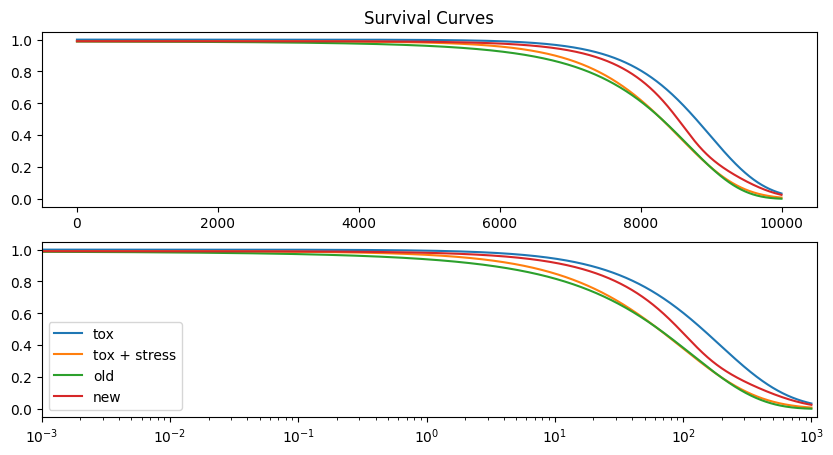

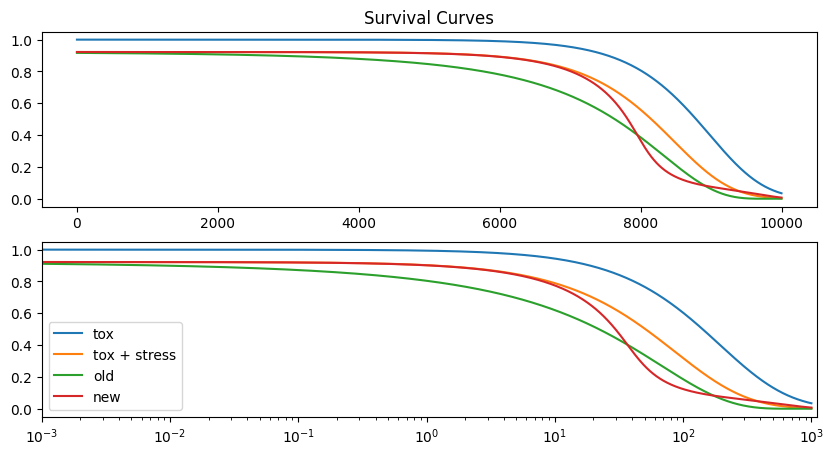

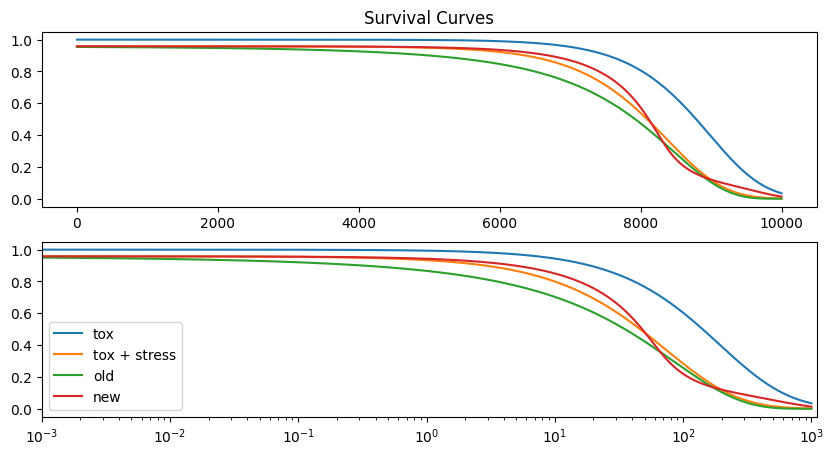

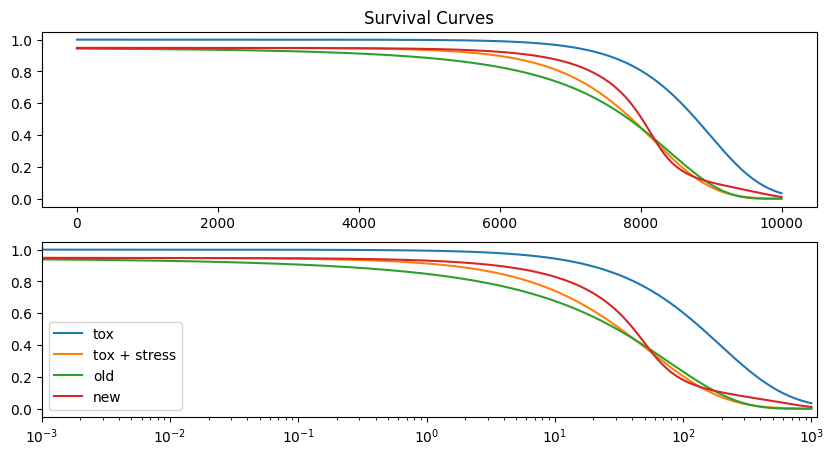

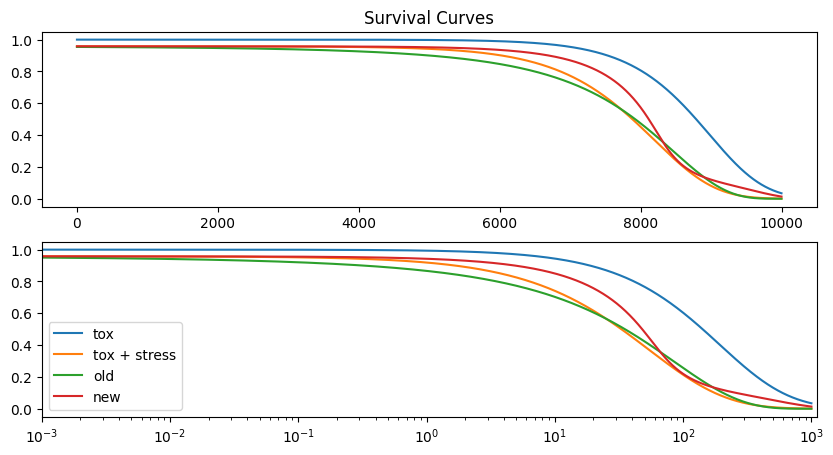

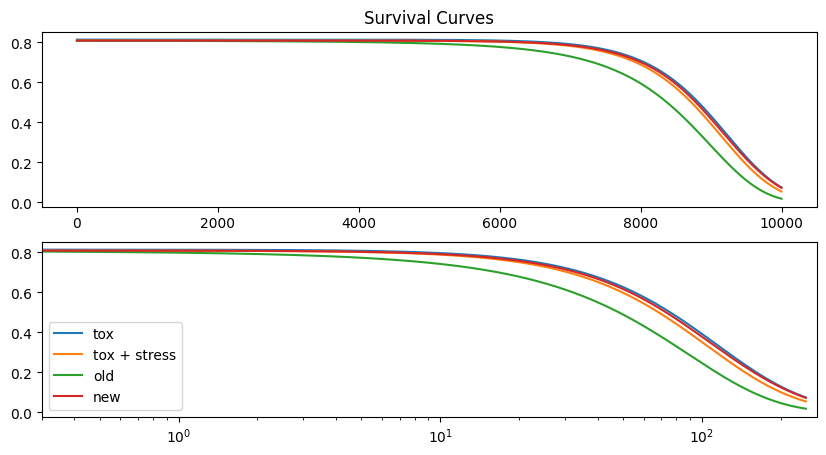

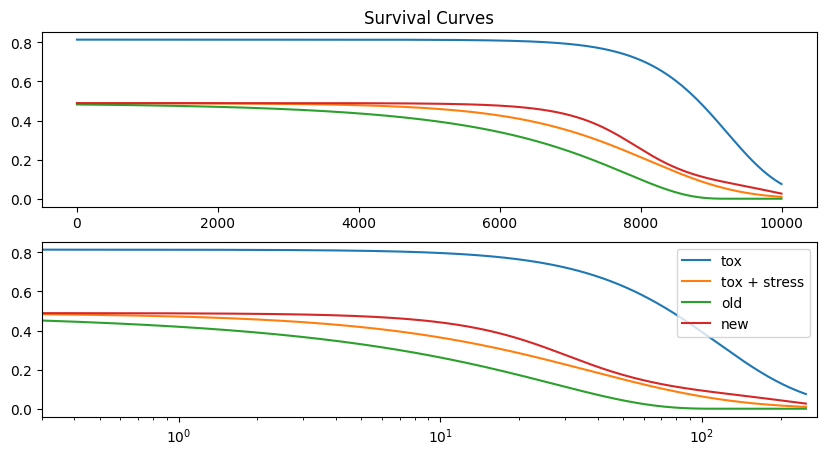

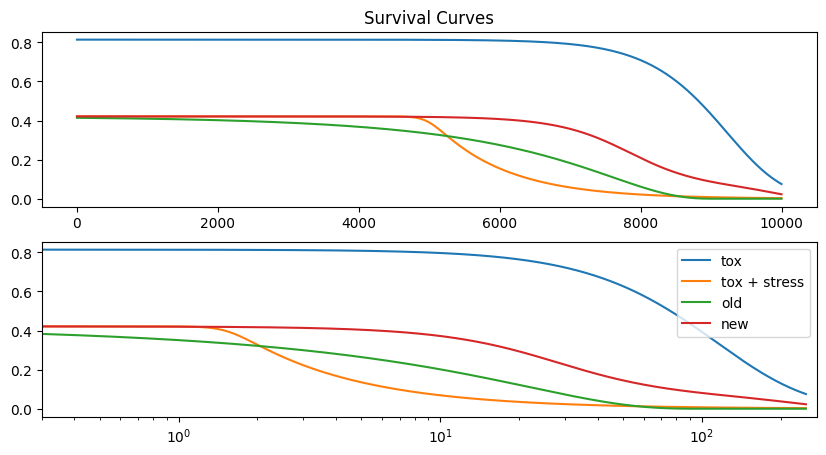

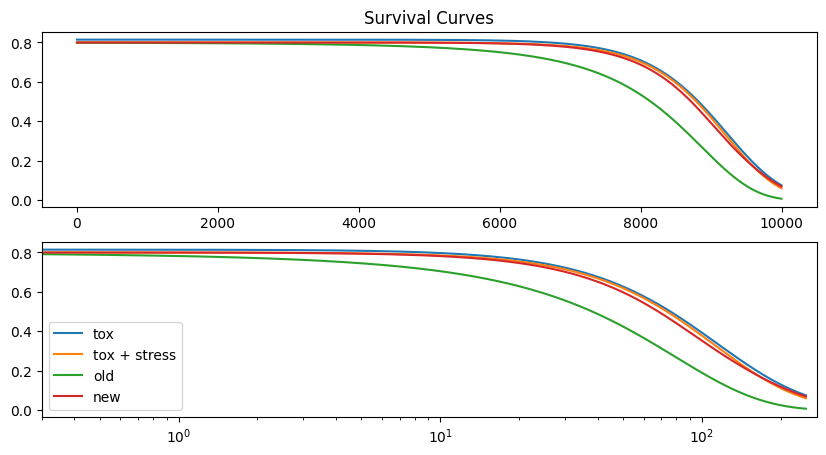

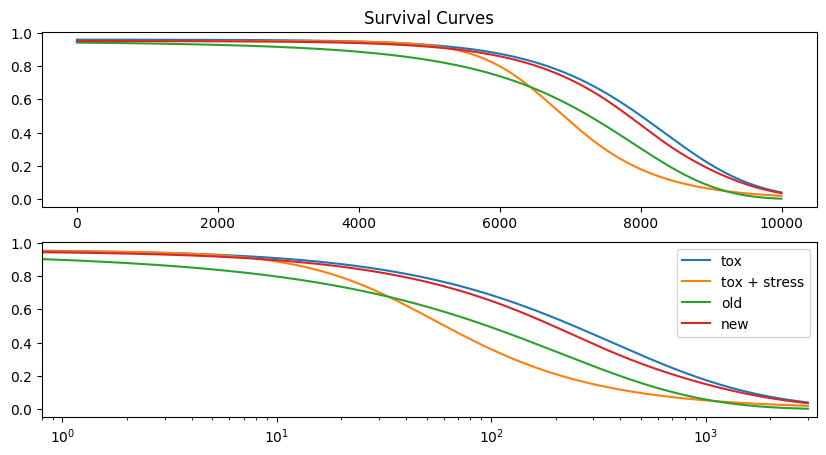

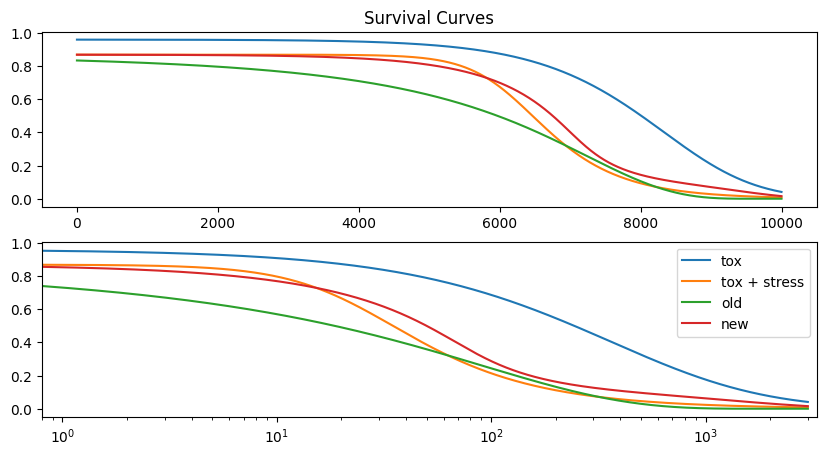

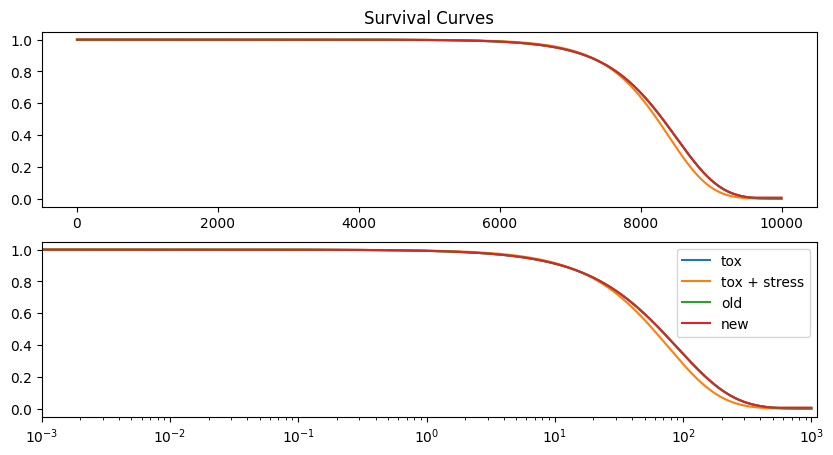

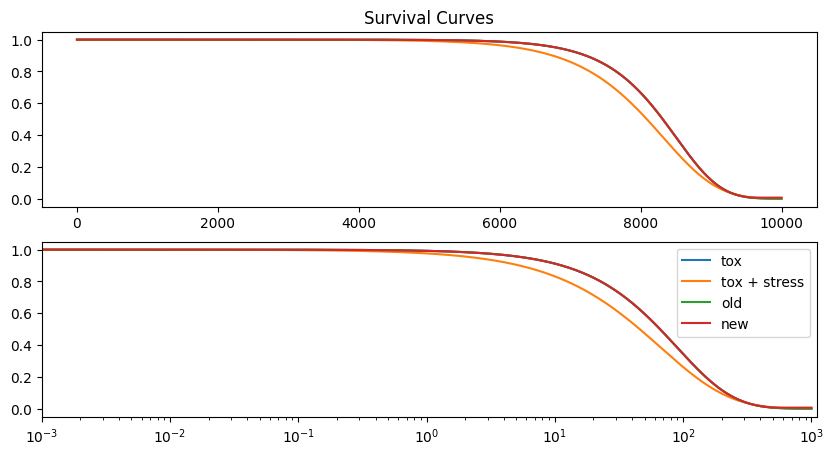

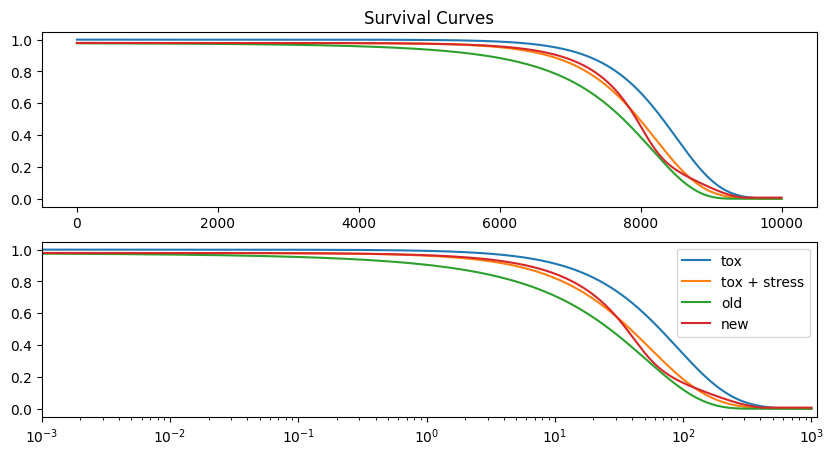

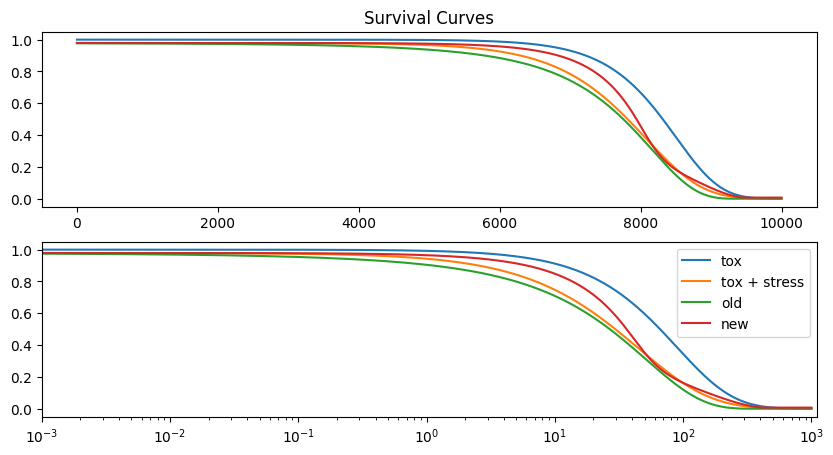

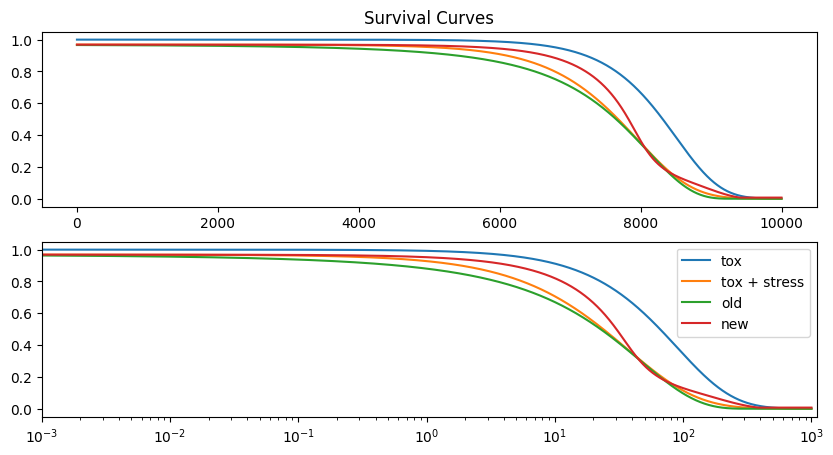

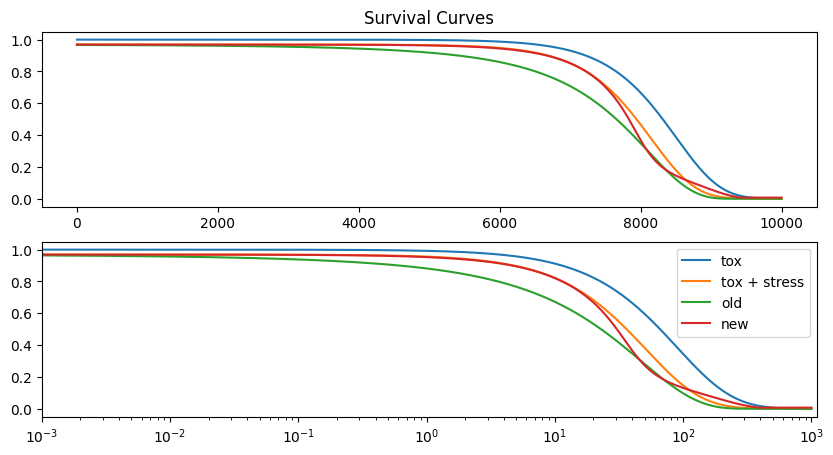

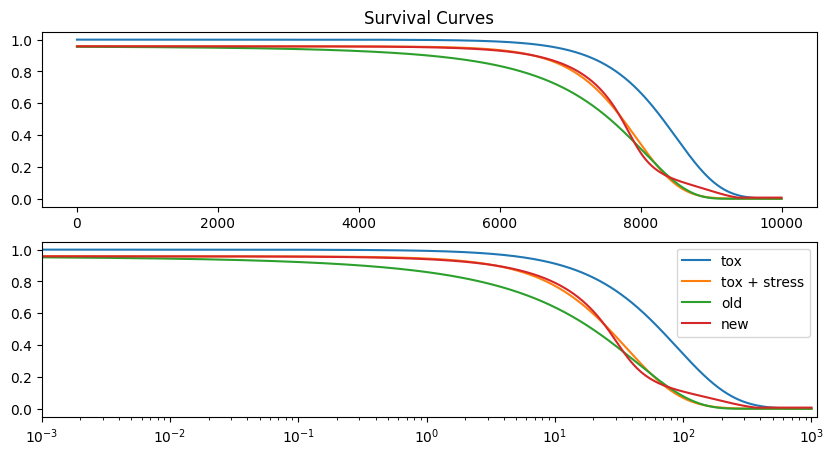

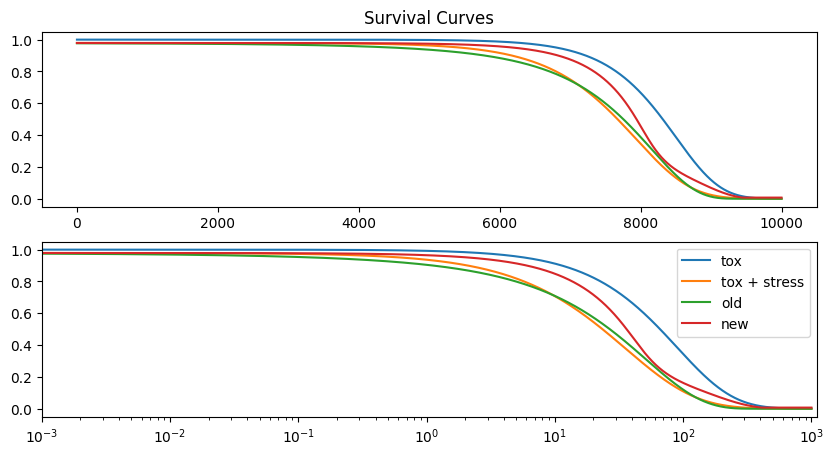

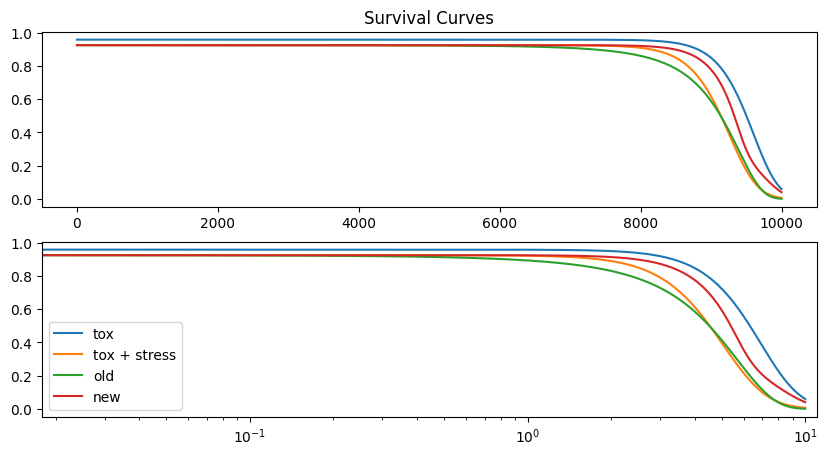

In [9]:
def sam_new(surv, main_c0, stress_c0):
    
    
    surv_stress, main_c0_stress, stress_c0_stress = map(surv_to_stress_new, (surv, main_c0, stress_c0))
    sam_stress = surv_stress + stress_c0_stress - main_c0_stress
    
    
    return stress_to_surv_new(sam_stress)


truths, old, new = [],[],[]

from stress_addition_model import sam_prediction, OLD_STANDARD

for data, stressor, main_fit, stress_fit in fits:
    data : ExperimentData
    
    old_pred = sam_prediction(data.main_series, data.additional_stress[stressor], data.meta, OLD_STANDARD)
    
    surv = main_fit.survival_curve / data.meta.max_survival
    surv_stress = stress_fit.survival_curve / data.meta.max_survival
    main_c0 = main_fit.optim_param["d"]
    stress_c0 = stress_fit.optim_param["d"]
    
    truths.append(surv_stress)
    
    old_pred[0].concentration_curve
    
    old_val = old_pred[2]/ data.meta.max_survival
    new_sam_pred = sam_new(surv, main_c0, stress_c0)
    old.append(old_val)
    new.append(new_sam_pred)
    
    plt.figure(figsize=(10,5))
    plt.subplot(2, 1,1)
    plt.title("Survival Curves")
    
    plt.plot(surv, label = "tox")
    plt.plot(surv_stress, label = "tox + stress")
    plt.plot(old_val, label = "old")
    plt.plot(new_sam_pred, label = "new")
    
    plt.subplot(2, 1,2)
    plt.plot(main_fit.concentration_curve, surv, label = "tox")
    plt.plot(main_fit.concentration_curve, surv_stress, label = "tox + stress")
    plt.plot(main_fit.concentration_curve, old_val, label = "old")
    plt.plot(main_fit.concentration_curve, new_sam_pred, label = "new")
    plt.xlim(data.main_series.concentration[1] * 0.1, main_fit.concentration_curve[-1]*1.1)
    plt.xscale("log")
    
    plt.legend()
    plt.show()

In [10]:
y_true = np.array(truths)
old_pred = np.array(old)
new_pred = np.array(new)

from sklearn.metrics import mean_squared_error, r2_score

mse_old = mean_squared_error(y_true, old_pred)
r2_old = r2_score(y_true, old_pred)

# Calculate metrics for new predictions
mse_new = mean_squared_error(y_true, new_pred)
r2_new = r2_score(y_true, new_pred)

# Print results nicely
print("Results Summary")
print("=" * 50)
print(f"{'Metric':<20} {'Old Prediction':<15} {'New Prediction':<15}")
print("-" * 50)
print(f"{'MSE':<20} {mse_old:<15.5f} {mse_new:<15.5f}")
print(f"{'R² Score':<20} {r2_old:<15.5f} {r2_new:<15.5f}")
print("=" * 50)

Results Summary
Metric               Old Prediction  New Prediction 
--------------------------------------------------
MSE                  0.00515         0.00497        
R² Score             0.82031         0.85338        
